In [2]:
import igraph as ig#version 0.10.4 returned Node with 17916 
import cairo
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df_label = pd.read_csv('Train-1542865627584.csv')

### 2.1 Load file

In [4]:
df_in = pd.read_csv('Inpatient_edge.csv')
df_out = pd.read_csv('Outpatient_edge.csv')
df_ful = pd.read_csv('Patient_edge.csv')
df_out

,Unnamed: 0,from,to,weight_count,weight_reimburse,weight_physician,weight_diagnosis,weight_procedure
0,0,PRV57595,PRV57610,25,8663.500,42.380,78.380,0.000
1,1,PRV55903,PRV55951,1,150.830,1.580,3.250,0.000
2,2,PRV55903,PRV56011,63,14580.170,101.390,159.590,0.000
3,3,PRV55951,PRV56011,103,26619.160,167.930,296.080,0.000
4,4,PRV56011,PRV56011,4670,1359510.060,7288.180,12659.520,0.000
...,...,...,...,...,...,...,...,...
149922,149922,PRV54668,PRV54894,1,80.000,1.000,2.000,0.000
149923,149923,PRV52021,PRV55913,1,200.000,2.500,2.000,0.000
149924,149924,PRV51836,PRV54337,11,2545.730,19.690,30.690,0.000
149925,149925,PRV51851,PRV54337,1,231.430,1.790,2.790,0.000


In [17]:
df_in = df_in[df_in['from'] != df_in['to']]
df_out = df_out[df_out['from'] != df_out['to']]
df_ful = df_ful[df_ful['from'] != df_ful['to']]
df_out

,Unnamed: 0,from,to,weight_count,weight_reimburse,weight_physician,weight_diagnosis,weight_procedure
0,0,PRV57595,PRV57610,25,8663.500,42.380,78.380,0.000
1,1,PRV55903,PRV55951,1,150.830,1.580,3.250,0.000
2,2,PRV55903,PRV56011,63,14580.170,101.390,159.590,0.000
3,3,PRV55951,PRV56011,103,26619.160,167.930,296.080,0.000
5,5,PRV52038,PRV54064,1,223.750,1.380,3.250,0.000
...,...,...,...,...,...,...,...,...
149922,149922,PRV54668,PRV54894,1,80.000,1.000,2.000,0.000
149923,149923,PRV52021,PRV55913,1,200.000,2.500,2.000,0.000
149924,149924,PRV51836,PRV54337,11,2545.730,19.690,30.690,0.000
149925,149925,PRV51851,PRV54337,1,231.430,1.790,2.790,0.000


### 2.2 Select edge data for each case

In [18]:
df_list = [df_in,df_out,df_ful]
columns = ['weight_count','weight_reimburse','weight_physician','weight_diagnosis','weight_procedure']
dataset = ['In','Out','Full']

selected_date_list = []
for df in df_list:
    df_selected_list = []
    for col in columns:
        sub_df = df[['from','to',col]].rename(columns={'from':'source','to':'target',col:'weight'})
        df_selected_list.append(sub_df)
    selected_date_list.append(df_selected_list)

### 2.3 Create Graph for each case

In [19]:
graph_list = []

for df in selected_date_list:
    df_graph_list = []
    for subset in df:
        df_graph_list.append(nx.from_pandas_edgelist(subset, edge_attr=True))
    graph_list.append(df_graph_list)

### 2.4 Calculate diameter, average shortest path for each graph

### 2.5 Find degree, betweenness, and closeness and attached to label file

In [20]:
df_label.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [21]:
naming = []
for i in dataset:
    for j in columns:
        naming.append(i+'_'+j)

In [22]:
def graph_to_df(graph, method):
    if method == '_Degree' or method == '_Degree_dist':
        output = nx.degree(graph,weight='weight')
        list_data = [(node, val) for (node, val) in output]
        result = pd.DataFrame(list_data, columns=['Provider', col_name+method])
    elif method == '_Betweenness' or method == '_Betweenness_dist':
        output = nx.betweenness_centrality(graph,weight='weight')
        result = pd.DataFrame(output.items(), columns=['Provider', col_name+method])
    else:
        output = nx.closeness_centrality(graph)
        result = pd.DataFrame(output.items(), columns=['Provider', col_name+method])
    return result

In [23]:
count = 0
for df_graph in graph_list:
    for graph in df_graph:
        col_name = naming[count]
        print(col_name)
        degree = graph_to_df(graph, '_Degree_dist')
        df_label = df_label.merge(degree,on='Provider',how='left')
        betweenness = graph_to_df(graph, '_Betweenness_dist')
        df_label = df_label.merge(betweenness,on='Provider',how='left')
        closeness = graph_to_df(graph, '_Closeness_dist')
        df_label = df_label.merge(closeness,on='Provider',how='left')
        count += 1

In_weight_count
In_weight_reimburse
In_weight_physician
In_weight_diagnosis
In_weight_procedure
Out_weight_count
Out_weight_reimburse
Out_weight_physician
Out_weight_diagnosis
Out_weight_procedure
Full_weight_count
Full_weight_reimburse
Full_weight_physician
Full_weight_diagnosis
Full_weight_procedure


In [24]:
df_label

,Provider,PotentialFraud,In_weight_count_Degree_dist,In_weight_count_Betweenness_dist,In_weight_count_Closeness_dist,In_weight_reimburse_Degree_dist,In_weight_reimburse_Betweenness_dist,In_weight_reimburse_Closeness_dist,In_weight_physician_Degree_dist,In_weight_physician_Betweenness_dist,...,Full_weight_reimburse_Closeness_dist,Full_weight_physician_Degree_dist,Full_weight_physician_Betweenness_dist,Full_weight_physician_Closeness_dist,Full_weight_diagnosis_Degree_dist,Full_weight_diagnosis_Betweenness_dist,Full_weight_diagnosis_Closeness_dist,Full_weight_procedure_Degree_dist,Full_weight_procedure_Betweenness_dist,Full_weight_procedure_Closeness_dist
0,PRV51001,No,7.000,0.000,0.164,236500.000,0.000,0.164,13.500,0.000,...,0.387,209.400,0.000,0.387,427.820,0.000,0.387,15.100,NaN,0.387
1,PRV51003,Yes,6.000,0.002,0.168,43233.340,0.002,0.168,12.340,0.002,...,0.408,927.900,0.000,0.408,2038.060,0.000,0.408,56.870,NaN,0.408
2,PRV51004,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.449,1169.770,0.002,0.449,2184.760,0.003,0.449,29.820,NaN,0.449
3,PRV51005,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.417,4424.240,0.000,0.417,8506.330,0.001,0.417,128.780,NaN,0.417
4,PRV51007,No,3.000,0.000,0.163,17166.660,0.000,0.163,4.160,0.000,...,0.390,546.920,0.000,0.390,1032.260,0.000,0.390,18.720,NaN,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.374,146.040,0.000,0.374,270.130,0.000,0.374,5.020,NaN,0.374
5406,PRV57760,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.281,121.890,0.000,0.281,197.220,0.000,0.281,0.000,NaN,0.281
5407,PRV57761,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.426,759.440,0.000,0.426,1556.210,0.000,0.426,33.830,NaN,0.426
5408,PRV57762,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.330,5.600,0.000,0.330,15.200,0.000,0.330,0.800,0.000,0.330


In [25]:
df_label.to_csv('model_data_dist.csv',index=False)

### 2.6 Draw graph for demo

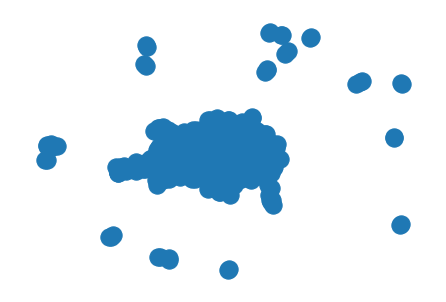

In [26]:
nx.draw(graph_list[0][0])

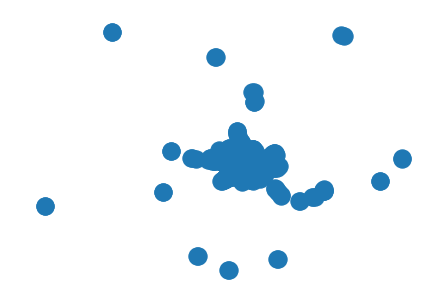

In [27]:
nx.draw(graph_list[0][1])

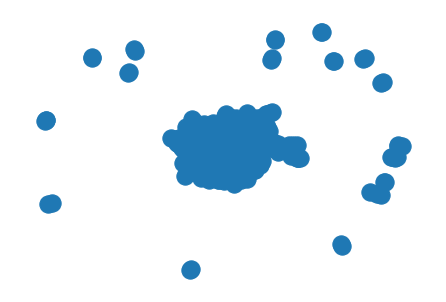

In [28]:
nx.draw(graph_list[0][2])

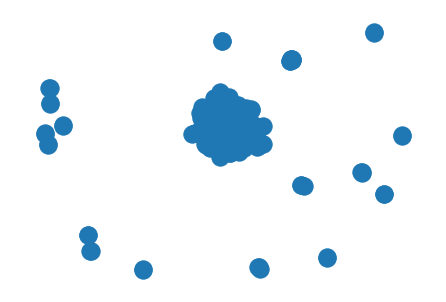

In [29]:
nx.draw(graph_list[0][3])

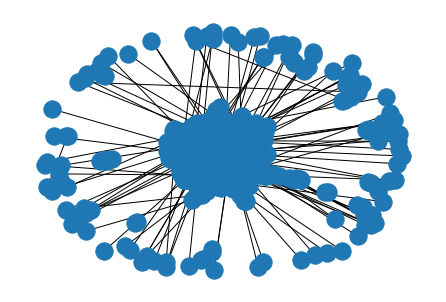

In [30]:
nx.draw(graph_list[0][4])

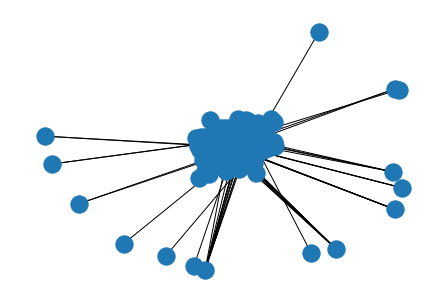

In [31]:
max_graph = graph.subgraph(max(nx.connected_components(graph_list[0][0]), key=len))
nx.draw(max_graph)

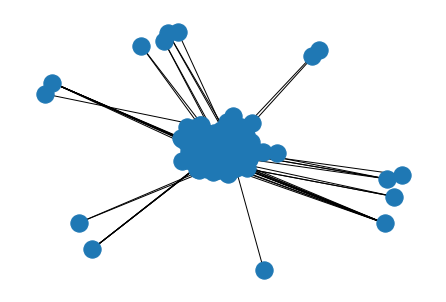

In [32]:
max_graph = graph.subgraph(max(nx.connected_components(graph_list[0][1]), key=len))
nx.draw(max_graph)

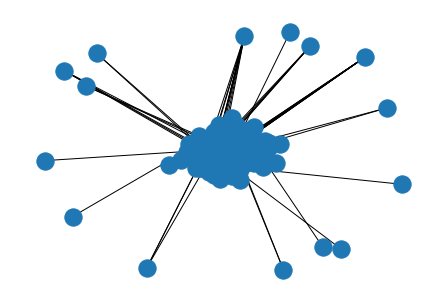

In [33]:
max_graph = graph.subgraph(max(nx.connected_components(graph_list[0][2]), key=len))
nx.draw(max_graph)

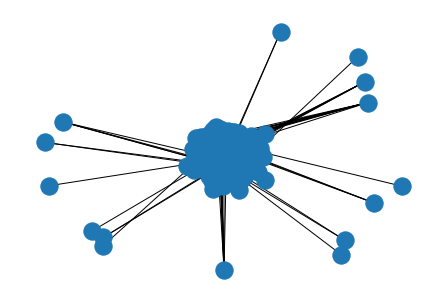

In [34]:
max_graph = graph.subgraph(max(nx.connected_components(graph_list[0][3]), key=len))
nx.draw(max_graph)

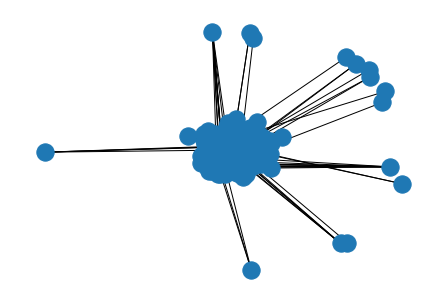

In [35]:
max_graph = graph.subgraph(max(nx.connected_components(graph_list[0][4]), key=len))
nx.draw(max_graph)